# Some explanations

## What is the pair correlation function?

In very short: the pair correlation function (aka radial distribution function) represents "the density of points found in average at a distance r of a given point in a sample".
See the [Wikipedia page](https://en.wikipedia.org/wiki/Radial_distribution_function) for more information (but I assume that you already are familiar with this notion if you are looking for a script that computes it).

## What do you mean by "corrected to take account of boundary effects"?

When the set of points is of finite size (which often occurs), some points near the boundaries will have less neighbours than what they would have in an infinite sample. This effect has to be corrected to properly compute the pair correlation function.

This scripts has two methods to deal with boundaries:
- the "normalization factors method": for the points that are too close to a boundary, the number of other points found at a given distance from them will be corrected to take account of the fact that in the bulk those particles should have more neighbours. This is the default behavior: all the points are considered (i.e. no data is lost), at the price of a time consuming computation.

- the "exclusion method": all the points that are too close to a boundary are simply excluded from the computation. In this case, the computation is faster, at the price of dropping some points (i.e. losing data).

# A simple example:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from paircorrelation2d import pcf2d

## Create a hexagonal-like array of points
This will be the set of points for which we want to compute the pair correlation function in this example

In [2]:
l_size=100 #the points will be placed in a square of size l_size*l_size
noise_amp=0.25 #we add some noise to mimic "real" data

col=np.arange(l_size)
points=np.zeros((l_size*l_size,2))

noise=np.random.rand(l_size*l_size,2)*noise_amp

for ii in range(l_size):
    points[ii*l_size:(ii+1)*l_size,0]=col+np.ones(l_size)*(1+(-1)**ii)/4+noise[ii*l_size:(ii+1)*l_size,0]
    points[ii*l_size:(ii+1)*l_size,1]=np.ones(l_size)*ii+noise[ii*l_size:(ii+1)*l_size,1]

Let's look at the set of points:

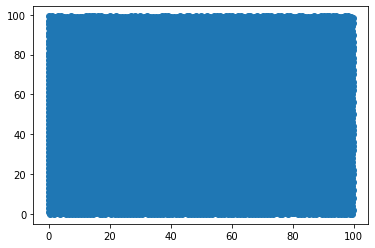

In [3]:
plt.scatter(points[:,0],points[:,1])

Let's look at a subset of points (to see the general pattern):

(10.0, 20.0, 10.0, 20.0)

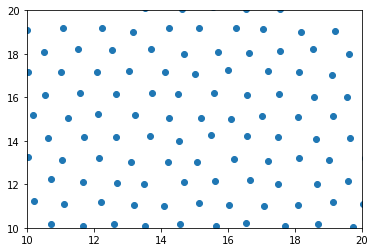

In [4]:
plt.scatter(points[:,0],points[:,1])
plt.axis([10,20,10,20])

## Compute the pair correlation function (pcf) taking account of all points:

In [5]:
bins=np.linspace(0,5,100) #Since the distance between two particles is about 1 here, 
#we choose to compute the pcf only for distances up to 5.

[g_of_r_all,r] = pcf2d(points,bins,show_timing=True)
#the "show_timing" argument let you knows how long the script takes to run

Creating boundary polygon and array of points inside took 0.065945 s
Creating all ring polygons took 0.015624 s
Computing normalization factors took 35.446779 s
Computing g(r) took 8.395403 s
Total time: 43.923752 s for 10000 points 


Here you can see that the total computation time is about 45 s (and that the computation of the normalization factor is the most time consuming operation).

Text(0.5, 1.0, 'Taking account of all points')

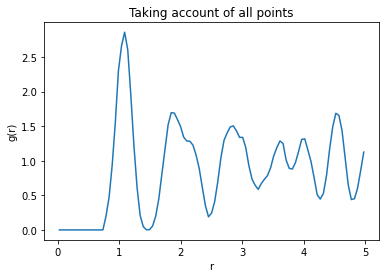

In [6]:
plt.plot(r,g_of_r_all)
plt.xlabel('r')
plt.ylabel('g(r)')
plt.title('Taking account of all points')

## Compute the pair correlation function (pcf) excluding points too close to the boundary:

In [7]:
[g_of_r_exclude,r] = pcf2d(points,bins,fast_method=True,show_timing=True)
#the "show_timing" argument let you knows how long the script takes to run

Creating boundary polygon and array of points inside took 0.068406 s
Creating all ring polygons took 0.016127 s
Computing normalization factors took 0.131497 s
Computing g(r) took 5.669641 s
Total time: 5.885671 s for 8093 points 


Here you can see that the total computation time is about 6 s (and that the computation of g(r) is faster than in the previous case because less points are considered).

Text(0.5, 1.0, 'Excluding points too close to the boundary')

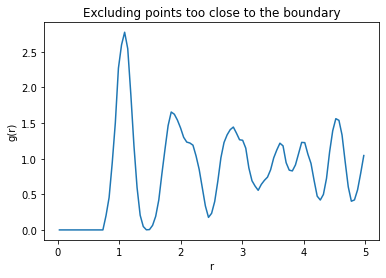

In [8]:
plt.plot(r,g_of_r_exclude)
plt.xlabel('r')
plt.ylabel('g(r)')
plt.title('Excluding points too close to the boundary')

## Wait, they look exactly the same, don't they?

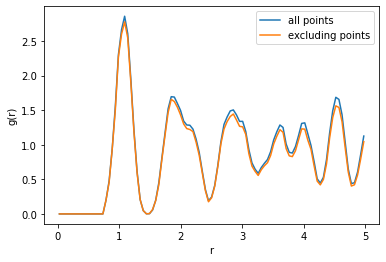

In [9]:
plt.plot(r,g_of_r_all,label='all points')
plt.plot(r,g_of_r_exclude,label='excluding points')
plt.xlabel('r')
plt.ylabel('g(r)')
plt.legend()

This is because we have a set of points that is "bulky" (enough points are at a distance > 5 from the boundaries), but this is not always the case.

## Let's take another set of points:

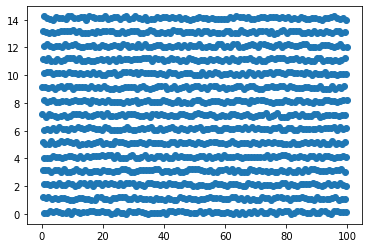

In [10]:
subpoints=points[np.where(points[:,1]<15)[0],:] #we exclude all the points with y>20

plt.scatter(subpoints[:,0],subpoints[:,1])

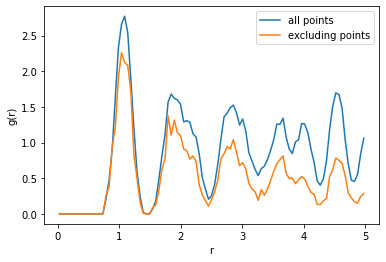

In [11]:
[g_of_r_all,r] = pcf2d(subpoints,bins)
[g_of_r_exclude,r] = pcf2d(subpoints,bins,fast_method=True)

plt.plot(r,g_of_r_all,label='all points')
plt.plot(r,g_of_r_exclude,label='excluding points')
plt.xlabel('r')
plt.ylabel('g(r)')
plt.legend()

Here the difference is more noticeable, because more than half of the points are close enough to a boundary (i.e. their distance to the boundary is less than 5, which is the maximal distance we want for computing g(r)).

# More information about boundaries:

## You can define the boundary you want for your set of points:
The scripts is based on the Polygon objects from [shapely](https://shapely.readthedocs.io/en/latest/manual.html#polygons) so any list of coordinates that creates a valid Polygon for shapely will work here. The scripts then automatically excludes the points that are not inside the area of interest you have defined.
For example, if ones want to do a L-shape boundary:

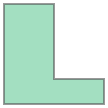

In [12]:
from shapely.geometry import Polygon

lshape_coord=np.array([[0,0],[100,0],[100,25],[50,25],[50,100],[0,100]])
lshape_poly=Polygon(lshape_coord) #this step is just for illustration purpose (it's not needed otherwise)
lshape_poly

You can now compute the g(r) for the points of your set that are inside this L-shape polygon (and you can verify what points are kept by using the "plot=True" option):

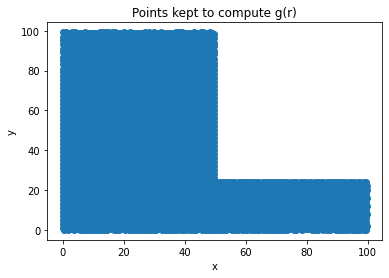

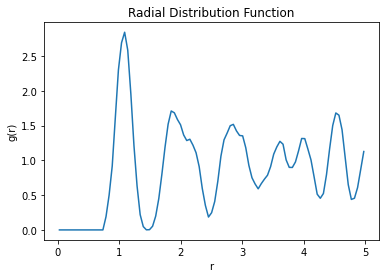

In [13]:
[g_of_r_lshape,r]=pcf2d(points,bins,coord_border=lshape_coord,plot=True)

## You can add holes in your area of interest:
This might be useful for example if you are looking at a set of particles coordinates that are in a geometry with obstacles (the positions of the obstacles are exclusion zones where no particles can ever be found, so you have to remove them from the area of interest).

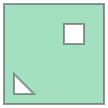

In [14]:
square_coord=np.array([[0,0],[0,100],[100,100],[100,0]])
holes_coord=[np.array([[10,10],[10,30],[30,10]]),np.array([[60,60],[60,80],[80,80],[80,60]])] #the coordinates of holes polygons must be into a list (even when there's only one)

poly_with_holes=Polygon(square_coord,holes_coord)#this step is just for illustration purpose (it's not needed otherwise)
poly_with_holes

You can now compute the g(r) for the points of your set that are inside this area of interest with holes (and you can verify what points are kept by using the "plot=True" option):

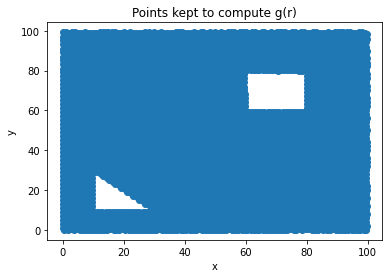

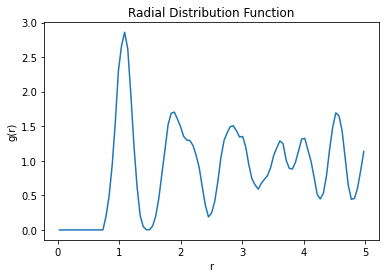

In [15]:
[g_of_r_holes,r]=pcf2d(points,bins,coord_border=square_coord,coord_holes=holes_coord,plot=True)

# Two things to keep in mind about boundaries:
- When no boundary is provided, the scripts computes the minimal convex polygon containing all the points in array_positions (the  convex hull). If the set of point has a non-convex boundary, the g(r) that will be computed will be wrong. For example, the convex hull of a L-shape set of points looks like this:

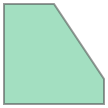

In [16]:
lshape_poly.convex_hull

- The list of coordinates you provide for the boundary of the area of interest has to be "valid" in the sens used by the shapely library: linking all the points in order should result in a simple polygon with no line intersecting each other. For example:

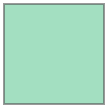

In [17]:
valid_square = Polygon([[0,0],[0,100],[100,100],[100,0]])
valid_square

This is a valid polygon.

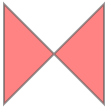

In [18]:
invalid_square = Polygon([[0,0],[0,100],[100,0],[100,100]])
invalid_square

This is an invalid polygon (made with the same coordinates, not in the same order).